# Reviewing ECMWF hindcasts 

## Check for possibility of a readiness trigger with a longer lead time

The current forecast (Meteo France La Reunion) provides limited lead time and we should explore if we could use ECMWF to have a readiness signal. I would basically check some basic perfomance metrics vs lead time and decide with partners what is acceptable.

In [1]:
%load_ext jupyter_black

import os
from datetime import datetime
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
from shapely.geometry import Point
from datetime import timedelta

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
save_dir = (
    Path(AA_DATA_DIR) / "public" / "exploration" / "moz" / "ecmwf_hindcast"
)
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date()
    for dt in gdf_points["ISO_TIME"]
]

In [4]:
# Define the function to categorize cyclones
def categorize_cyclone(wind_speed):
    if wind_speed > 115:
        return "Very Intense Tropical Cyclone"
    elif wind_speed >= 90:
        return "Intense Tropical Cyclone"
    elif wind_speed >= 64:
        return "Tropical Cyclone"
    elif wind_speed >= 48:
        return "Severe Tropical Storm"
    elif wind_speed >= 34:
        return "Moderate Tropical Storm"
    elif wind_speed >= 28:
        return "Tropical Depression"
    else:
        return "Tropical Disturbance"


# Confidence intervals function
def calculate_confidence_interval(counts, total):
    if total == 0:
        return np.nan, np.nan
    proportion = counts / total
    stderr = np.sqrt((proportion * (1 - proportion)) / total)
    margin_of_error = stderr * stats.norm.ppf(0.975)  # 95% confidence interval
    return (
        proportion * 100 - margin_of_error * 100,
        proportion * 100 + margin_of_error * 100,
    )


# Define storm categories in order of intensity
category_order = {
    "Tropical Disturbance": 1,
    "Tropical Depression": 2,
    "Tropical Storm": 3,
    "Severe Tropical Storm": 4,
    "Tropical Cyclone": 5,
    "Intense Tropical Cyclone": 6,
    "Very Intense Tropical Cyclone": 7,
}

In [5]:
categories = [name for name, order in category_order.items() if order >= 4]

In [6]:
gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * 0.88
)

In [7]:
# testing for cyclone Freddy
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])
gdf_points_cyclone = gdf_points[gdf_points["NAME"] == "FREDDY"]
cyclone_file = pd.read_csv(save_dir / f"csv/freddy_all.csv")
cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])
cyclone_df = (
    cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
    .groupby(["time", "forecast_time"])
    .median()
    .reset_index()
)
df = pd.merge(
    gdf_points_cyclone,
    cyclone_df,
    left_on="ISO_TIME",
    right_on="time",
    how="inner",
)
df["speed_knots"] = df["speed"] * 1.94384
# Apply the function to create a new column "storm_category"
df["actual_storm_category"] = df["REU_USA_WIND"].apply(categorize_cyclone)
df["forecasted_storm_category"] = df["speed_knots"].apply(categorize_cyclone)

In [8]:
df[
    [
        "lead_time",
        "actual_storm_category",
        "forecasted_storm_category",
        "LAT",
        "LON",
        "lat",
        "lon",
    ]
][df["REU_USA_WIND"] > 34]

,lead_time,actual_storm_category,forecasted_storm_category,LAT,LON,lat,lon
20,48.0,Moderate Tropical Storm,Tropical Depression,-22.5,39.6,-21.8,39.9
21,36.0,Moderate Tropical Storm,Tropical Depression,-22.5,39.6,-21.8,40.2
22,24.0,Moderate Tropical Storm,Tropical Depression,-22.5,39.6,-21.8,39.6
23,12.0,Moderate Tropical Storm,Tropical Depression,-22.5,39.6,-22.1,40.1
24,0.0,Moderate Tropical Storm,Moderate Tropical Storm,-22.5,39.6,-22.5,40.3
...,...,...,...,...,...,...,...
477,48.0,Moderate Tropical Storm,Moderate Tropical Storm,-17.0,35.2,-17.1,35.4
478,36.0,Moderate Tropical Storm,Tropical Depression,-17.0,35.2,-16.7,35.2
479,24.0,Moderate Tropical Storm,Tropical Depression,-17.0,35.2,-16.5,35.4
480,12.0,Moderate Tropical Storm,Tropical Depression,-17.0,35.2,-16.7,35.2


### Checking how long it would take to make landfall after crossing certain longitudes

In [9]:
moz_cyclones = [
    Path(f).stem.replace("_all", "").upper()
    for f in glob.glob(str(Path(save_dir) / "csv" / "*_all.csv"))
]

In [10]:
def compute_average_landfall_time_per_longitude(
    gdf_points, lon_start, lon_end, gdf_sel, moz_cyclones
):
    lon_range = range(lon_start, lon_end + 1)
    avg_landfall_times = []

    for lon in lon_range:
        landfall_times = []

        for cyclone_name in moz_cyclones:
            gdf_points_yr = gdf_points[gdf_points["year"] >= 1980]
            cyclone_gdf = gdf_points_yr[gdf_points_yr["NAME"] == cyclone_name]

            if cyclone_gdf.empty:
                continue

            # Convert ISO_TIME to datetime
            cyclone_gdf["ISO_TIME"] = pd.to_datetime(cyclone_gdf["ISO_TIME"])

            if cyclone_gdf.empty:
                continue

            cyclone_gdf = cyclone_gdf.sort_values(by="ISO_TIME")

            crossing_time = None
            landfall_time = None

            # Identify crossing of the longitude
            for _, row in cyclone_gdf.iterrows():
                if row["LON"] <= lon and crossing_time is None:
                    crossing_time = row["ISO_TIME"]

                # Remove data points after crossing
                if crossing_time and row["LON"] > lon:
                    break

            if crossing_time:
                # Check if cyclone made landfall within gdf_sel
                for _, row in cyclone_gdf.iterrows():
                    point = Point(row["LON"], row["LAT"])
                    if gdf_sel.contains(point).any():
                        landfall_time = row["ISO_TIME"]
                        break

                if landfall_time:
                    time_to_landfall = (
                        landfall_time - crossing_time
                    ).total_seconds() / 3600  # in hours
                    landfall_times.append(time_to_landfall)

        if landfall_times:
            average_landfall_time = np.mean(landfall_times)
            avg_landfall_times.append((lon, average_landfall_time))
        else:
            avg_landfall_times.append(
                (lon, np.nan)
            )  # No data for this longitude

    return avg_landfall_times


# Define longitude range
lon_start = 35
lon_end = 50

# Compute average landfall times
avg_landfall_times = compute_average_landfall_time_per_longitude(
    gdf_points, lon_start, lon_end, gdf_sel, moz_cyclones
)

# Convert results to DataFrame for easier plotting
df_results = pd.DataFrame(
    avg_landfall_times, columns=["Longitude", "Average_Time_to_Landfall"]
)

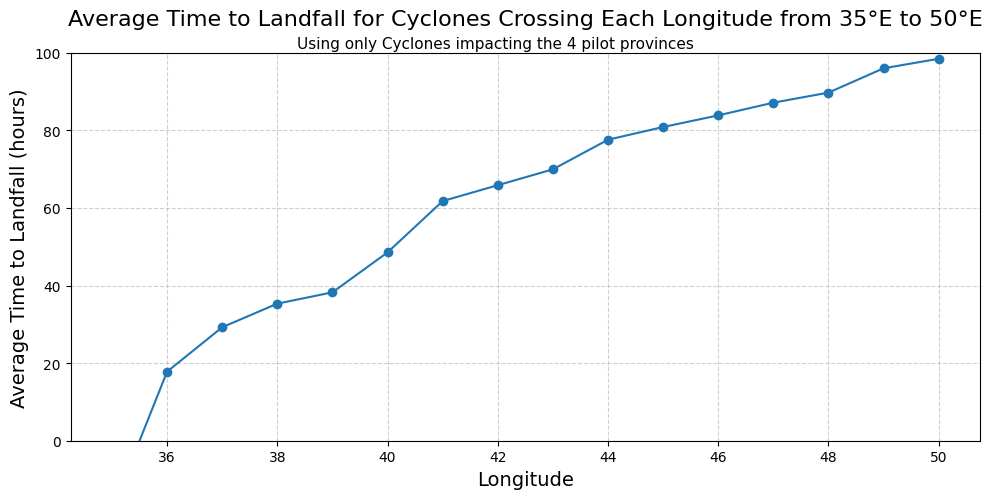

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
    df_results["Longitude"], df_results["Average_Time_to_Landfall"], marker="o"
)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Average Time to Landfall (hours)", fontsize=14)
plt.ylim(0, 100)
plt.title(
    "Average Time to Landfall for Cyclones Crossing Each Longitude from 35°E to 50°E",
    fontsize=16,
    pad=20,  # Adds space between title and plot
)
plt.suptitle(
    "Using only Cyclones impacting the 4 pilot provinces",
    fontsize=11,  # Subtitle font size
    y=0.78,  # Adjust subtitle position; should be slightly below the title
)
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust layout to fit title and subtitle
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### Getting the location error in km

In [12]:
# Function to compute distance between two points using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # Earth radius in kilometers
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [13]:
# Function to check if a point is within the region defined by gdf_sel
def is_within_region(lat, lon, gdf_region):
    point = Point(lon, lat)
    return gdf_region.geometry.contains(point).any()


def get_province(lat, lon, gdf_provinces):
    point = Point(lon, lat)
    for index, row in gdf_provinces.iterrows():
        if row.geometry.contains(point):
            return row["ADM1_PT"]
    return None

### Getting the location error over all points on land

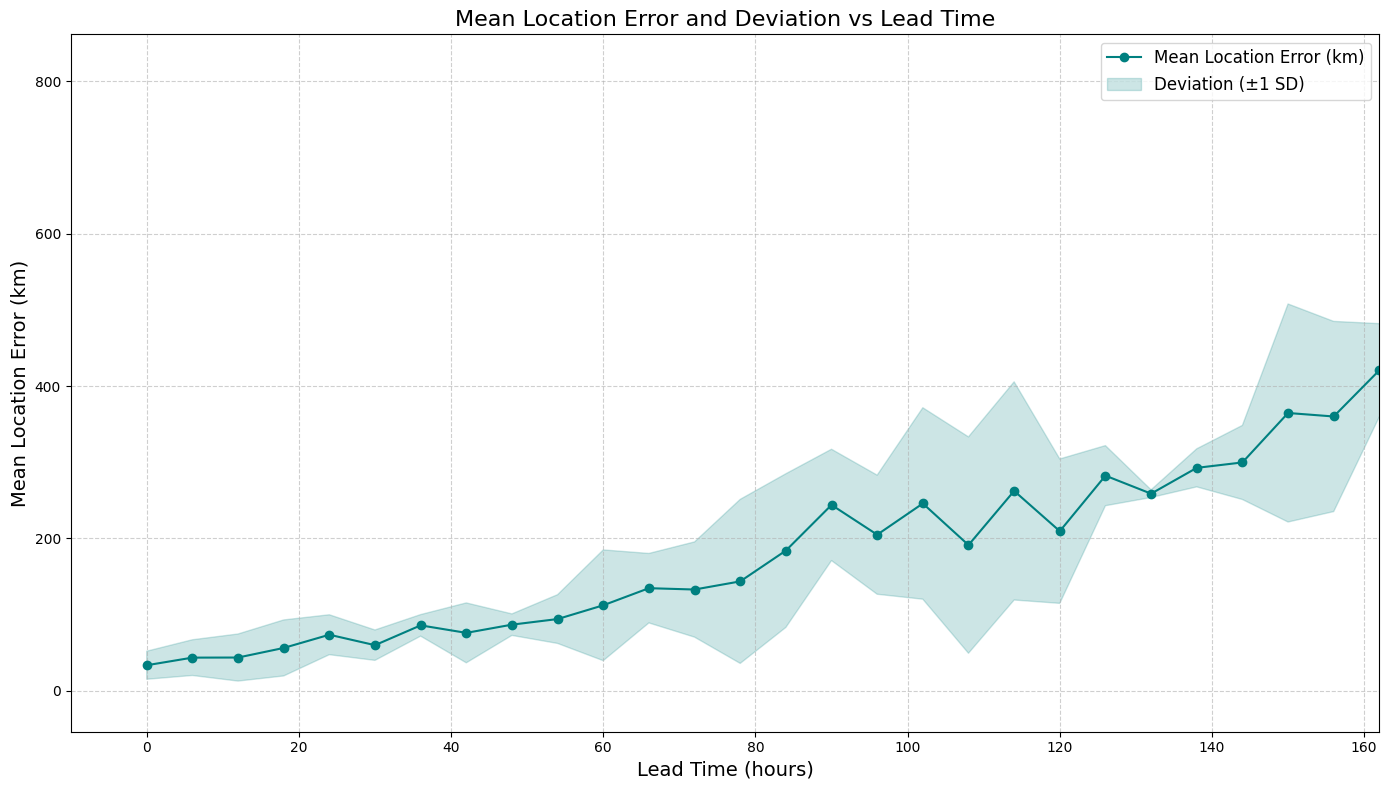

In [18]:
# Function to compute the location error metrics
def compute_location_error_metrics(
    gdf_points, save_dir, gdf_sel, storm_categories=[]
):
    # Initialize lists to store metrics
    all_metrics = []

    # Iterate over all cyclone files
    for cyclone_file_path in glob.glob(str(save_dir / "csv/*_all.csv")):
        cyclone_name = Path(cyclone_file_path).stem.split("_")[0]

        gdf_points_cyclone = gdf_points[
            gdf_points["NAME"] == cyclone_name.upper()
        ]
        gdf_points_cyclone["ISO_TIME"] = pd.to_datetime(
            gdf_points_cyclone["ISO_TIME"]
        )

        cyclone_file = pd.read_csv(cyclone_file_path)
        cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])

        cyclone_df = (
            cyclone_file[
                ["time", "speed", "lat", "lon", "lead_time", "forecast_time"]
            ]
            .groupby(["time", "forecast_time"])
            .median()
            .reset_index()
        )
        cyclone_df["lat"] = cyclone_df["lat"].apply(
            lambda x: -x if x > 0 else x
        )

        df = pd.merge(
            gdf_points_cyclone,
            cyclone_df,
            left_on="ISO_TIME",
            right_on="time",
            how="inner",
        )

        # Check if actual points are within the region
        df["actual_within_region"] = df.apply(
            lambda row: is_within_region(row["LAT"], row["LON"], gdf_sel),
            axis=1,
        )

        # Filter out forecasts that are not within the region
        df = df[df["actual_within_region"]]

        # Check if forecasted location is within the region
        df["forecast_within_region"] = df.apply(
            lambda row: is_within_region(row["lat"], row["lon"], gdf_sel),
            axis=1,
        )

        # Calculate the distance error using the Haversine formula
        df["location_error_km"] = df.apply(
            lambda row: haversine(
                row["LON"], row["LAT"], row["lon"], row["lat"]
            ),
            axis=1,
        )

        # Filter by storm categories if provided
        if storm_categories:
            df = df[df["actual_storm_category"].isin(storm_categories)]

        # Group by 'lead_time' and calculate the mean and standard deviation of location error
        metrics_by_lead_time_location = (
            df.groupby(["lead_time"])
            .agg(
                {
                    "location_error_km": ["mean", "std"],
                    "forecast_within_region": "mean",
                }
            )
            .reset_index()
        )

        # Flatten the multi-level columns
        metrics_by_lead_time_location.columns = [
            "lead_time",
            "mean_location_error_km",
            "std_location_error_km",
            "mean_forecast_within_region",
        ]

        # Append metrics to the list
        all_metrics.append(metrics_by_lead_time_location)

    if not all_metrics:
        raise ValueError(
            "No metrics were collected. Please check the files and data."
        )

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    return combined_metrics


combined_metrics = compute_location_error_metrics(
    gdf_points=gdf_points,
    save_dir=save_dir,
    gdf_sel=gdf_sel,
    storm_categories=None,  # List of categories to filter by
)
combined_metrics = combined_metrics.groupby("lead_time").mean().reset_index()
# Create a line plot with deviation
plt.figure(figsize=(14, 8))

# Plot the mean location error as a line
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["mean_location_error_km"],
    color="teal",
    marker="o",
    linestyle="-",
    label="Mean Location Error (km)",
)

# Fill the area between the mean ± standard deviation
plt.fill_between(
    combined_metrics["lead_time"],
    combined_metrics["mean_location_error_km"]
    - combined_metrics["std_location_error_km"],
    combined_metrics["mean_location_error_km"]
    + combined_metrics["std_location_error_km"],
    color="teal",
    alpha=0.2,
    label="Deviation (±1 SD)",
)

# Add plot details
plt.xlabel("Lead Time (hours)", fontsize=14)
plt.ylabel("Mean Location Error (km)", fontsize=14)
plt.title("Mean Location Error and Deviation vs Lead Time", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(-10, 162)
# Display the plot
plt.tight_layout()
plt.show()

### Location error only for landfall location

### Landfall Location distance from forecast

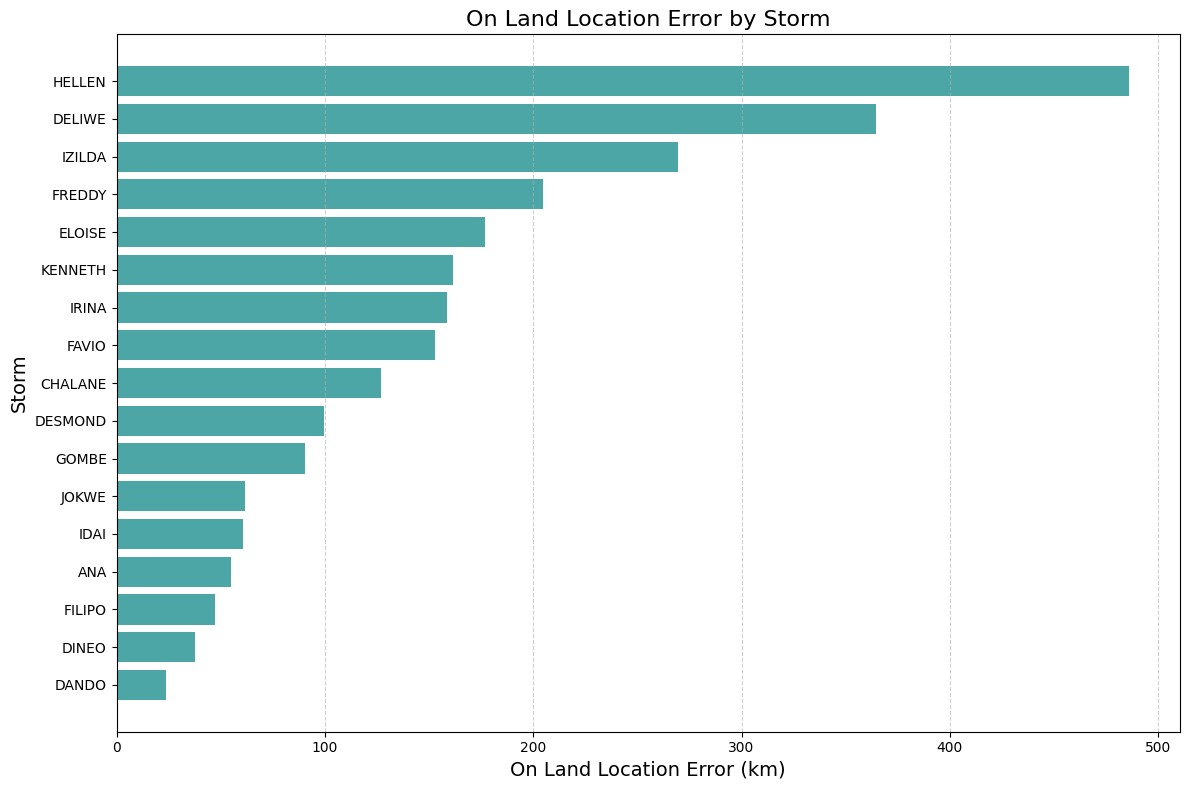

In [218]:
def compute_location_error_metrics_by_category(
    gdf_points, save_dir, gdf_sel, storm_categories=[]
):
    # Initialize lists to store metrics
    all_metrics = []

    # Iterate over all cyclone files
    for cyclone_file_path in glob.glob(str(save_dir / "csv/*_all.csv")):
        cyclone_name = Path(cyclone_file_path).stem.split("_")[0]

        gdf_points_cyclone = gdf_points[gdf_points["NAME"] == cyclone_name.upper()]
        gdf_points_cyclone["ISO_TIME"] = pd.to_datetime(gdf_points_cyclone["ISO_TIME"])

        cyclone_file = pd.read_csv(cyclone_file_path)
        cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])

        cyclone_df = (
            cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
            .groupby(["time", "forecast_time"])
            .median()
            .reset_index()
        )
        cyclone_df["lat"] = cyclone_df["lat"].apply(lambda x: -x if x > 0 else x)
        df = pd.merge(
            gdf_points_cyclone,
            cyclone_df,
            left_on="ISO_TIME",
            right_on="time",
            how="inner",
        )

        # Ensure columns are correctly referenced
        df["actual_within_region"] = df.apply(
            lambda row: is_within_region(row["LAT"], row["LON"], gdf_sel),
            axis=1,
        )

        df = df[
            df["actual_within_region"]
        ]  # Filter out forecasts not within the region

        df["forecast_within_region"] = df.apply(
            lambda row: is_within_region(row["lat"], row["lon"], gdf_sel),
            axis=1,
        )

        # Calculate location error
        df["location_error_km"] = df.apply(
            lambda row: haversine(row["LON"], row["LAT"], row["lon"], row["lat"]),
            axis=1,
        )

        # Filter by storm categories if provided
        if storm_categories:
            df = df[df["actual_storm_category"].isin(storm_categories)]

        # Find the first landfall point for each storm
        first_landfall_df = (
            df[df["actual_within_region"]]
            .groupby("NAME")
            .mean(["location_error_km"])
            .reset_index()
        )

        # Group by storm category and calculate metrics
        metrics_by_category = first_landfall_df[["NAME", "location_error_km"]]

        # Append metrics to the list
        all_metrics.append(metrics_by_category)

    if not all_metrics:
        raise ValueError("No metrics were collected. Please check the files and data.")

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    return combined_metrics


combined_metrics = compute_location_error_metrics_by_category(
    gdf_points=gdf_points,
    save_dir=save_dir,
    gdf_sel=gdf_sel,
    storm_categories=None,  # List of categories to filter by
)

combined_metrics_sorted = combined_metrics.sort_values(
    by="location_error_km", ascending=True
)

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(
    combined_metrics_sorted["NAME"],
    combined_metrics_sorted["location_error_km"],
    color="teal",
    alpha=0.7,
)

# Add plot details
plt.xlabel("On Land Location Error (km)", fontsize=14)
plt.ylabel("Storm", fontsize=14)
plt.title("On Land Location Error by Storm", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

### How close to the landfall location is the forecast?

In [355]:
# Function to compute the location error metrics
# Initialize lists to store metrics
all_metrics = []

# Iterate over all cyclone files
for cyclone_file_path in glob.glob(str(save_dir / "csv/*_all.csv")):
    cyclone_name = Path(cyclone_file_path).stem.split("_")[0]

    gdf_points_cyclone = gdf_points[gdf_points["NAME"] == cyclone_name.upper()]
    gdf_points_cyclone["ISO_TIME"] = pd.to_datetime(gdf_points_cyclone["ISO_TIME"])

    cyclone_file = pd.read_csv(cyclone_file_path)
    cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])

    cyclone_df = (
        cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
        .groupby(["time", "forecast_time"])
        .median()
        .reset_index()
    )
    cyclone_df["lat"] = cyclone_df["lat"].apply(lambda x: -x if x > 0 else x)

    df = pd.merge(
        gdf_points_cyclone,
        cyclone_df,
        left_on="ISO_TIME",
        right_on="time",
        how="outer",
    )

    # Check if actual points are within the region
    df["actual_within_region"] = df.apply(
        lambda row: is_within_region(row["LAT"], row["LON"], gdf_sel),
        axis=1,
    )

    # Check if forecasted location is within the region
    df["forecast_within_region"] = df.apply(
        lambda row: is_within_region(row["lat"], row["lon"], gdf_sel),
        axis=1,
    )

    actual_landfall = df[df["actual_within_region"]]["ISO_TIME"].min()
    if pd.isnull(actual_landfall):
        continue
    errors = []

    for lt, lt_df in df.groupby("forecast_time"):
        forecast_landfall = lt_df[lt_df["forecast_within_region"]]["time"].min()
        if pd.isnull(forecast_landfall):
            continue
        if not pd.isnull(forecast_landfall):
            actual_lon = df[df["ISO_TIME"] == actual_landfall]["LON"].min()
            actual_lat = df[df["ISO_TIME"] == actual_landfall]["LAT"].min()
            forecast_lon = df[df["time"] == forecast_landfall]["lon"].min()
            forecast_lat = df[df["time"] == forecast_landfall]["lat"].min()

            lt_df["landfall_error_km"] = lt_df.apply(
                lambda row: haversine(
                    actual_lon, actual_lat, forecast_lon, forecast_lat
                ),
                axis=1,
            )

            # Append relevant data to errors list
            for _, row in lt_df.iterrows():
                errors.append(
                    {
                        "lead_time": row["lead_time"],
                        "landfall_error_km": row["landfall_error_km"],
                    }
                )
    if len(errors) > 0:
        # Convert errors list to DataFrame
        errors_df = pd.DataFrame(errors)
        errors_df = errors_df.groupby("lead_time").mean().reset_index()

    all_metrics.append(errors_df)

# Combine all metrics
combined_metrics = pd.concat(all_metrics)

### Getting the location error by checking if it will make landfall within the 4 provinces

### For all lead times

Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\favio_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\jokwe_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\izilda_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\dando_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\irina_all.csv
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\haruna_all.

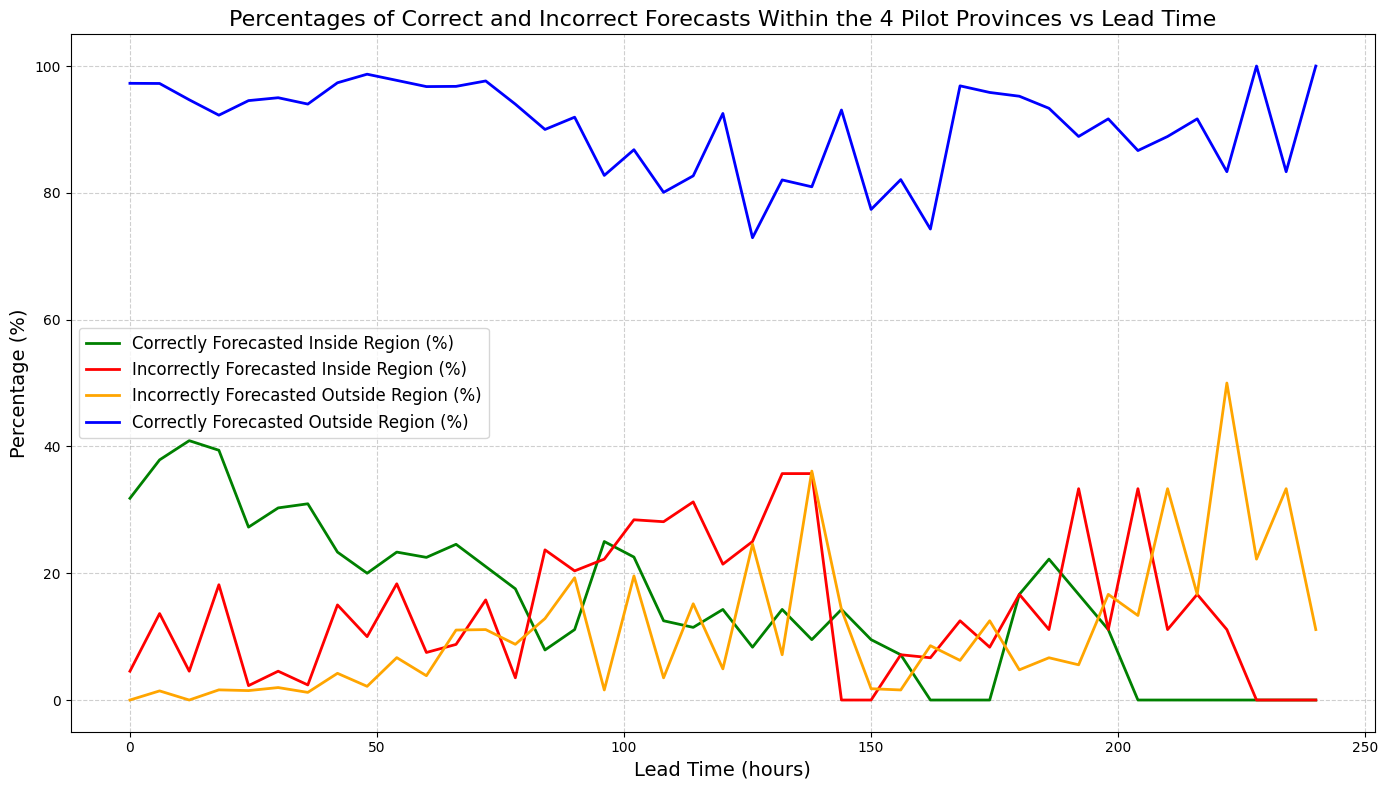

In [212]:
def compute_within_region_metrics(gdf_points, save_dir, gdf_sel):
    # Initialize lists to store metrics
    all_metrics = []

    # Iterate over all cyclone files
    for cyclone_file_path in glob.glob(str(save_dir / "csv/*_all.csv")):
        cyclone_name = Path(cyclone_file_path).stem.split("_")[0]
        print(f"Processing file: {cyclone_file_path}")

        gdf_points_cyclone = gdf_points[gdf_points["NAME"] == cyclone_name.upper()]
        gdf_points_cyclone["ISO_TIME"] = pd.to_datetime(gdf_points_cyclone["ISO_TIME"])

        if gdf_points_cyclone.empty:
            print(f"No data found for cyclone: {cyclone_name}")
            continue

        cyclone_file = pd.read_csv(cyclone_file_path)
        cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])

        cyclone_df = (
            cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
            .groupby(["time", "forecast_time"])
            .median()
            .reset_index()
        )
        cyclone_df["lat"] = cyclone_df["lat"].apply(lambda x: -x if x > 0 else x)
        df = pd.merge(
            gdf_points_cyclone,
            cyclone_df,
            left_on="ISO_TIME",
            right_on="time",
            how="inner",
        )

        if df.empty:
            print(f"After merging, no data found for cyclone: {cyclone_name}")
            continue

        # Check if forecasted location is within the region
        df["forecast_within_region"] = df.apply(
            lambda row: is_within_region(row["lat"], row["lon"], gdf_sel),
            axis=1,
        )

        # Check if actual location is within the region
        df["actual_within_region"] = df.apply(
            lambda row: is_within_region(row["LAT"], row["LON"], gdf_sel),
            axis=1,
        )

        def calculate_metrics(df):
            # Correctly Forecasted as Inside Region
            correct_positive = df[
                (df["forecast_within_region"]) & (df["actual_within_region"])
            ]
            # Incorrectly Forecasted as Inside Region
            false_positive = df[
                (df["forecast_within_region"]) & (~df["actual_within_region"])
            ]
            # Incorrectly Forecasted as Outside Region
            false_negative = df[
                (~df["forecast_within_region"]) & (df["actual_within_region"])
            ]
            # Correctly Forecasted as Outside Region
            correct_negative = df[
                (~df["forecast_within_region"]) & (~df["actual_within_region"])
            ]

            num_within_region = len(df[df["actual_within_region"]])
            num_outside_region = len(df[~df["actual_within_region"]])

            percentage_correct_positive = (
                (len(correct_positive) / num_within_region * 100)
                if num_within_region > 0
                else 0
            )
            percentage_false_positive = (
                (len(false_positive) / num_within_region * 100)
                if num_within_region > 0
                else 0
            )
            percentage_false_negative = (
                (len(false_negative) / num_outside_region * 100)
                if num_outside_region > 0
                else 0
            )
            percentage_correct_negative = (
                (len(correct_negative) / num_outside_region * 100)
                if num_outside_region > 0
                else 0
            )

            return pd.Series(
                {
                    "percentage_correct_positive": percentage_correct_positive,
                    "percentage_false_positive": percentage_false_positive,
                    "percentage_false_negative": percentage_false_negative,
                    "percentage_correct_negative": percentage_correct_negative,
                }
            )

        # Group by 'lead_time' and calculate metrics
        metrics_df = df.groupby("lead_time").apply(calculate_metrics).reset_index()
        all_metrics.append(metrics_df)

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    # Group by lead time and get the mean
    combined_metrics = combined_metrics.groupby("lead_time").mean().reset_index()

    return combined_metrics


# Example usage:
# Assuming gdf_points is your GeoDataFrame with actual points,
# save_dir is your directory containing cyclone files,
# and gdf_sel is your selected region GeoDataFrame.
combined_metrics = compute_within_region_metrics(gdf_points, save_dir, gdf_sel)

# Plotting the results
plt.figure(figsize=(14, 8))

# Line plot for mean percentages
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percentage_correct_positive"],
    color="green",
    linestyle="-",
    linewidth=2,
    label="Correctly Forecasted Inside Region (%)",
)

plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percentage_false_positive"],
    color="red",
    linestyle="-",
    linewidth=2,
    label="Incorrectly Forecasted Inside Region (%)",
)

plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percentage_false_negative"],
    color="orange",
    linestyle="-",
    linewidth=2,
    label="Incorrectly Forecasted Outside Region (%)",
)

plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percentage_correct_negative"],
    color="blue",
    linestyle="-",
    linewidth=2,
    label="Correctly Forecasted Outside Region (%)",
)

# Add plot details
plt.xlabel("Lead Time (hours)", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.title(
    "Percentages of Correct and Incorrect Forecasts Within the 4 Pilot Provinces vs Lead Time",
    fontsize=16,
)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

### For the 4 provinces


Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\favio_all.csv
Processing province: Inhambane
Processing province: Nampula
Processing province: Sofala
Processing province: Zambezia
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\jokwe_all.csv
Processing province: Inhambane
Processing province: Nampula
Processing province: Sofala
Processing province: Zambezia
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hindcast\csv\izilda_all.csv
Processing province: Inhambane
Processing province: Nampula
Processing province: Sofala
Processing province: Zambezia
Processing file: G:\Shared drives\Predictive Analytics\CERF Anticipatory Action\General - All AA projects\Data\public\exploration\moz\ecmwf_hind

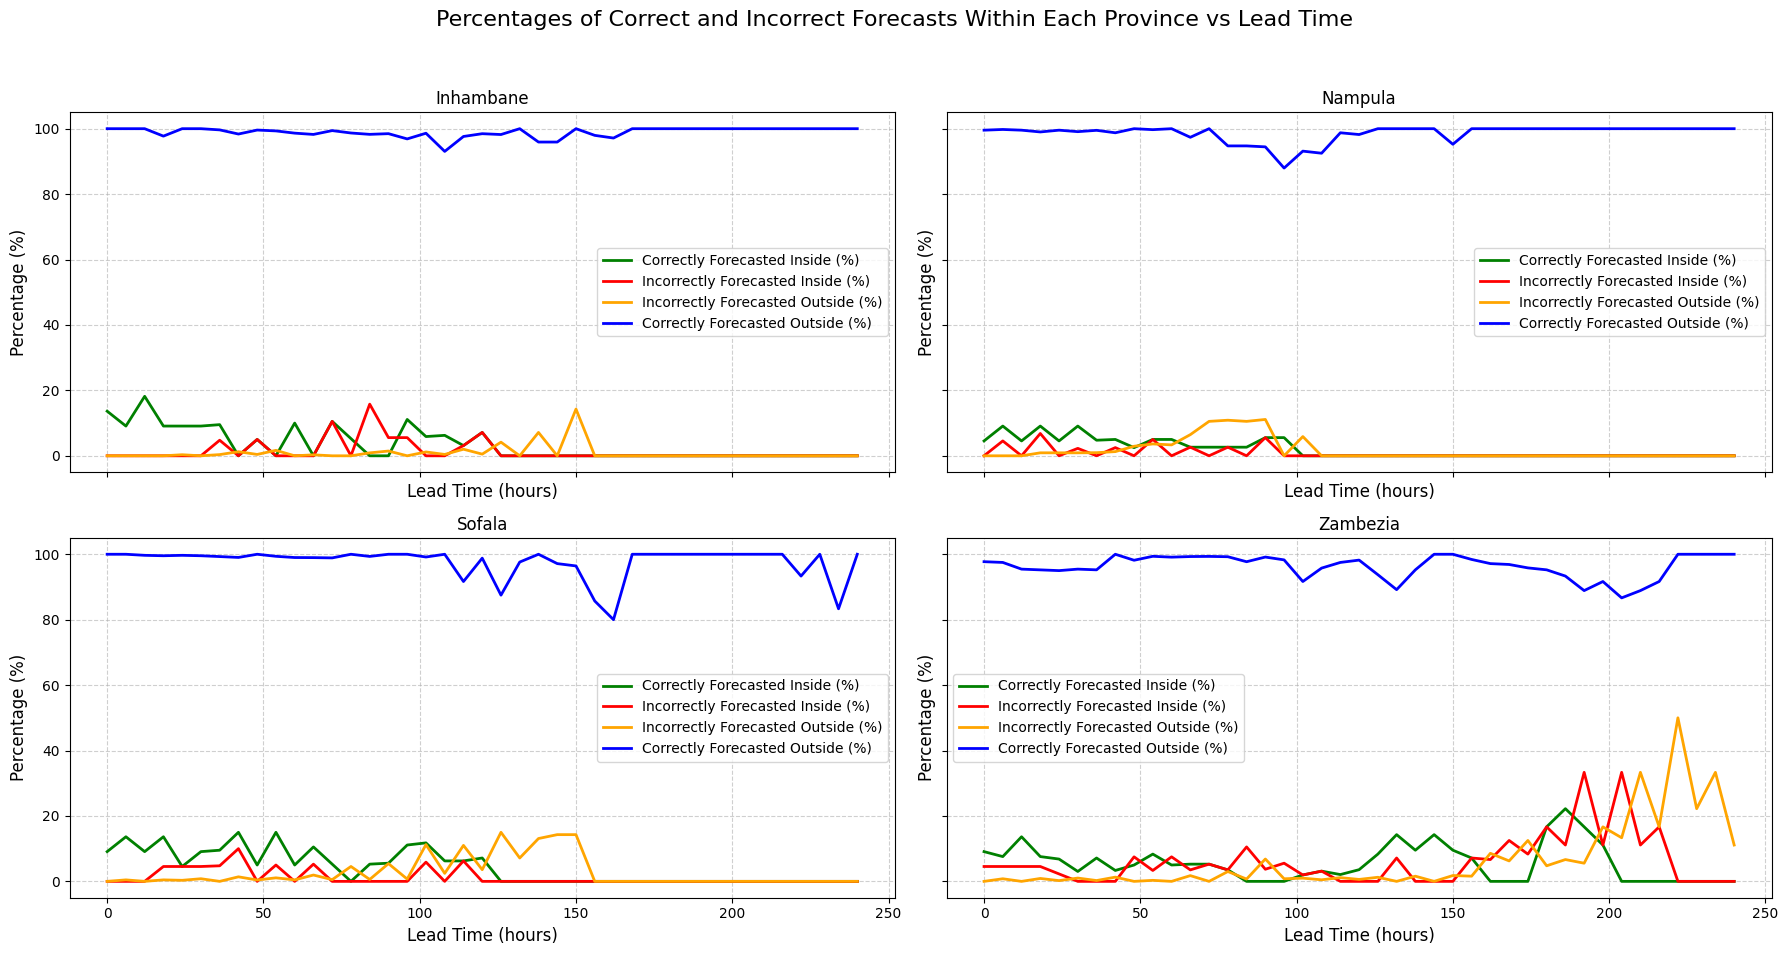

In [270]:
def compute_within_region_metrics(gdf_points, save_dir, gdf_sel):
    # Initialize lists to store metrics
    all_metrics = []

    # Iterate over all cyclone files
    for cyclone_file_path in glob.glob(str(save_dir / "csv/*_all.csv")):
        cyclone_name = Path(cyclone_file_path).stem.split("_")[0]
        print(f"Processing file: {cyclone_file_path}")

        gdf_points_cyclone = gdf_points[gdf_points["NAME"] == cyclone_name.upper()]
        gdf_points_cyclone["ISO_TIME"] = pd.to_datetime(gdf_points_cyclone["ISO_TIME"])

        if gdf_points_cyclone.empty:
            print(f"No data found for cyclone: {cyclone_name}")
            continue

        cyclone_file = pd.read_csv(cyclone_file_path)
        cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])

        cyclone_df = (
            cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
            .groupby(["time", "forecast_time"])
            .median()
            .reset_index()
        )
        cyclone_df["lat"] = cyclone_df["lat"].apply(lambda x: -x if x > 0 else x)
        df = pd.merge(
            gdf_points_cyclone,
            cyclone_df,
            left_on="ISO_TIME",
            right_on="time",
            how="inner",
        )

        if df.empty:
            print(f"After merging, no data found for cyclone: {cyclone_name}")
            continue

        # Iterate over each province in gdf_sel
        for province_name in gdf_sel["ADM1_PT"].unique():
            print(f"Processing province: {province_name}")

            gdf_province = gdf_sel[gdf_sel["ADM1_PT"] == province_name]

            # Check if forecasted location is within the province
            df["forecast_within_province"] = df.apply(
                lambda row: is_within_region(row["lat"], row["lon"], gdf_province),
                axis=1,
            )

            # Check if actual location is within the province
            df["actual_within_province"] = df.apply(
                lambda row: is_within_region(row["LAT"], row["LON"], gdf_province),
                axis=1,
            )

            def calculate_metrics(df):
                # Correctly Forecasted as Inside Province
                correct_positive = df[
                    (df["forecast_within_province"]) & (df["actual_within_province"])
                ]
                # Incorrectly Forecasted as Inside Province
                false_positive = df[
                    (df["forecast_within_province"]) & (~df["actual_within_province"])
                ]
                # Incorrectly Forecasted as Outside Province
                false_negative = df[
                    (~df["forecast_within_province"]) & (df["actual_within_province"])
                ]
                # Correctly Forecasted as Outside Province
                correct_negative = df[
                    (~df["forecast_within_province"]) & (~df["actual_within_province"])
                ]

                num_within_province = len(df[df["actual_within_province"]])
                num_outside_province = len(df[~df["actual_within_province"]])

                percentage_correct_positive = (
                    (len(correct_positive) / num_within_province * 100)
                    if num_within_province > 0
                    else 0
                )
                percentage_false_positive = (
                    (len(false_positive) / num_within_province * 100)
                    if num_within_province > 0
                    else 0
                )
                percentage_false_negative = (
                    (len(false_negative) / num_outside_province * 100)
                    if num_outside_province > 0
                    else 0
                )
                percentage_correct_negative = (
                    (len(correct_negative) / num_outside_province * 100)
                    if num_outside_province > 0
                    else 0
                )

                return pd.Series(
                    {
                        "percentage_correct_positive": percentage_correct_positive,
                        "percentage_false_positive": percentage_false_positive,
                        "percentage_false_negative": percentage_false_negative,
                        "percentage_correct_negative": percentage_correct_negative,
                    }
                )

            # Calculate metrics for each lead time separately
            metrics_df = df.groupby("lead_time").apply(calculate_metrics).reset_index()
            metrics_df["province"] = province_name  # Add province name
            all_metrics.append(metrics_df)

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    # Group by province and lead time, then get the mean
    combined_metrics = (
        combined_metrics.groupby(["province", "lead_time"]).mean().reset_index()
    )

    return combined_metrics


# Example usage:
combined_metrics = compute_within_region_metrics(gdf_points, save_dir, gdf_sel)

# Plotting the results
provinces = combined_metrics["province"].unique()

fig, axs = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)
fig.suptitle(
    "Percentages of Correct and Incorrect Forecasts Within Each Province vs Lead Time",
    fontsize=16,
)
colors = ["green", "red", "orange", "blue"]

for i, province in enumerate(provinces):
    ax = axs[i // 2, i % 2]
    province_data = combined_metrics[combined_metrics["province"] == province]

    ax.plot(
        province_data["lead_time"],
        province_data["percentage_correct_positive"],
        color="green",
        linestyle="-",
        linewidth=2,
        label="Correctly Forecasted Inside (%)",
    )
    ax.plot(
        province_data["lead_time"],
        province_data["percentage_false_positive"],
        color="red",
        linestyle="-",
        linewidth=2,
        label="Incorrectly Forecasted Inside (%)",
    )
    ax.plot(
        province_data["lead_time"],
        province_data["percentage_false_negative"],
        color="orange",
        linestyle="-",
        linewidth=2,
        label="Incorrectly Forecasted Outside (%)",
    )
    ax.plot(
        province_data["lead_time"],
        province_data["percentage_correct_negative"],
        color="blue",
        linestyle="-",
        linewidth=2,
        label="Correctly Forecasted Outside (%)",
    )

    ax.set_title(province)
    ax.set_xlabel("Lead Time (hours)", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(loc="best", fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()